<a href="https://colab.research.google.com/github/mppenfold/aihc5615/blob/main/HWweek5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Homework 3 -MPP


In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# my gdrive
file_path = '/content/drive/MyDrive/MayoML/AIHC5615FundofStats/week5/kc_house_data.csv'
df = pd.read_csv(file_path)
display(df.head())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503



***4 cont variables: sqft_living, sqft_lot, sqft_above, sqft_below***


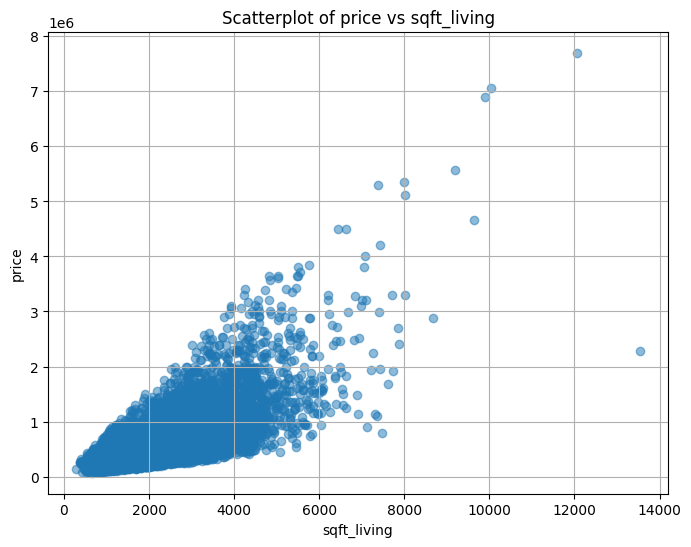

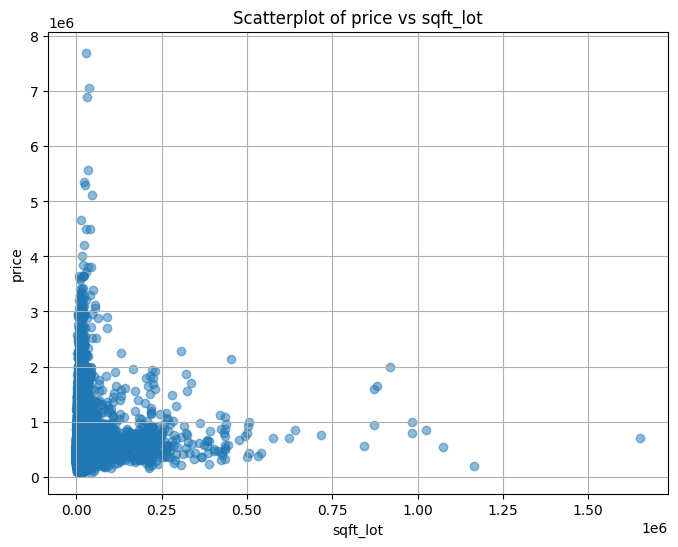

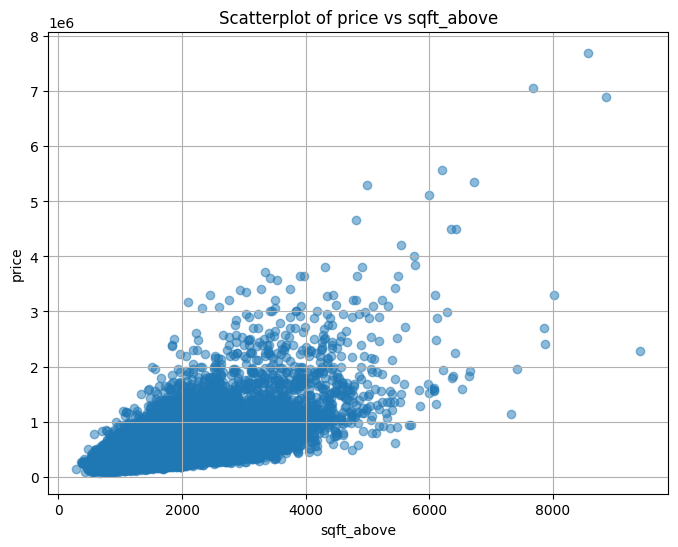

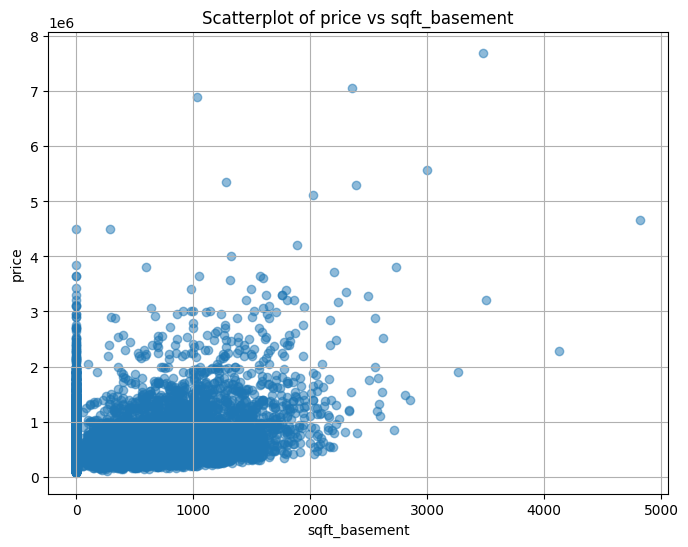

In [42]:
# define vars
continuous_vars = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
response_var = 'price'
for var in continuous_vars:
    plt.figure(figsize=(8, 6))
    plt.scatter(x=df[var], y=df[response_var], alpha=0.5)
    plt.title(f'Scatterplot of {response_var} vs {var}')
    plt.xlabel(var)
    plt.ylabel(response_var)
    plt.grid(True)
    plt.show()

Calculated the 99.75th percentile for each variable and removed all values above.

In [43]:
# vars for outlier removal
outlier_vars = ['sqft_living', 'sqft_above', 'sqft_basement', 'sqft_lot']
#remove 0.25%
percentile_threshold = 0.9975

# calc 99.75th %tile value and define as variable threshold
thresholds = {}
for var in outlier_vars:
    thresholds[var] = df[var].quantile(percentile_threshold)

# clean df thru removal of any variables less than or equal to calculated threshold
df_cleaned = df.copy()
for var, threshold in thresholds.items():
    df_cleaned = df_cleaned[df_cleaned[var] <= threshold]

print(f"Original number of homes: {df.shape[0]}")
print(f"Number of homes after removing top 0.25% outliers for each variable: {df_cleaned.shape[0]}")
print(f"Number of homes removed: {df.shape[0] - df_cleaned.shape[0]}")
print(f"Percentage of homes removed: {((df.shape[0] - df_cleaned.shape[0]) / df.shape[0]) * 100:.2f}%")


Original number of homes: 21613
Number of homes after removing top 0.25% outliers for each variable: 21444
Number of homes removed: 169
Percentage of homes removed: 0.78%


In [44]:
from sklearn.model_selection import train_test_split
import os

# train/test/val split
train_proportion = 0.60
test_proportion = 0.20
validation_proportion = 0.20

# split off train set
df_train, df_temp = train_test_split(df_cleaned, train_size=train_proportion, random_state=24)

# split remaining 40% evenly into test/val groups
df_val, df_test = train_test_split(df_temp, train_size=0.5, random_state=42)

print(f"Original dataset size: {df_cleaned.shape[0]}")
print(f"Training set size: {df_train.shape[0]} ({df_train.shape[0]/df_cleaned.shape[0]:.2%})")
print(f"Validation set size: {df_val.shape[0]} ({df_val.shape[0]/df_cleaned.shape[0]:.2%})")
print(f"Test set size: {df_test.shape[0]} ({df_test.shape[0]/df_cleaned.shape[0]:.2%})")

# savedir
save_dir = '/content/drive/MyDrive/MayoML/AIHC5615FundofStats/week5/'

# path
train_file_path = os.path.join(save_dir, 'train_data.csv')
val_file_path = os.path.join(save_dir, 'validation_data.csv')
test_file_path = os.path.join(save_dir, 'test_data.csv')

# create csv
df_train.to_csv(train_file_path, index=False)
df_val.to_csv(val_file_path, index=False)
df_test.to_csv(test_file_path, index=False)


Original dataset size: 21444
Training set size: 12866 (60.00%)
Validation set size: 4289 (20.00%)
Test set size: 4289 (20.00%)


h0 = no significant difference in mean house price regardless of waterfront location or not

h0: mean_waterfront = mean_no_waterfront

h1 = there is a significant difference in mean price of houses with a waterfront compared to those without a waterfront
h1: mean_waterfront ≠ mean_no_waterfront

I will compare mean price of each group using two sided T-test, could be that waterfront causes an increase (or decrease) in house prices and my alternate hypothesis doesnt argue any direction with respect to changes in price.

In [45]:
# assign vars from training set
waterfront_homes = df_train[df_train['waterfront'] == 1]
non_waterfront_homes = df_train[df_train['waterfront'] == 0]

from scipy.stats import ttest_ind

waterfront_prices = waterfront_homes['price']
non_waterfront_prices = non_waterfront_homes['price']

# t-test (independent)
t_statistic, p_value = ttest_ind(waterfront_prices, non_waterfront_prices, equal_var=False)

print("Hypothesis testing: two sided t-test)")
print(f"  Test stat: {t_statistic:.4f}")
print(f"  p-value: {p_value:.4f}")
print("Using significant value of 0.05 I would reject the null hyopthesis and conclude there is a signifcant difference between the prices of homes with and without a waterfront")

Hypothesis testing: two sided t-test)
  Test stat: 9.5259
  p-value: 0.0000
Using significant value of 0.05 I would reject the null hyopthesis and conclude there is a signifcant difference between the prices of homes with and without a waterfront


/tmp/ipython-input-566853014.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(price_data, labels=['Waterfront', 'No waterfront'])


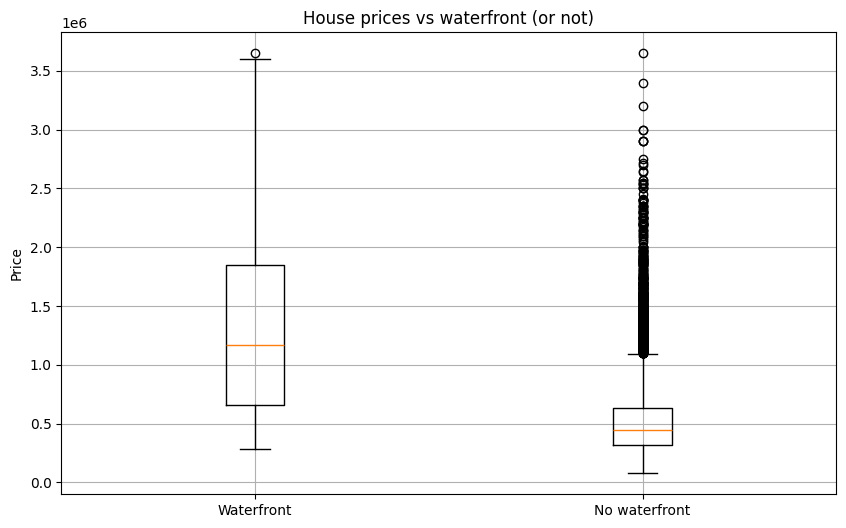

In [46]:
# list prices
price_data = [waterfront_prices, non_waterfront_prices]

# figure
plt.figure(figsize=(10, 6))
plt.boxplot(price_data, labels=['Waterfront', 'No waterfront'])
plt.title('House prices vs waterfront (or not)')
plt.ylabel('Price')
plt.grid(True)
plt.show()

Homes with a waterfront have a higher mean and median price as compared to those without a waterfront.

There interquartile ranges are larger for homes with waterfronts meaning the prices vary more than those without a waterfront.

Comparing prices vs floors (limited to one or two story homes). Using a two sided t-test to determine if there is a significant difference in price (higher/lower).

H0: there is no difference in the cost of a single story home vs a two story home.

H1: There is a significant difference between the cost of a single story and a two story home.

In [47]:
# define and fileter variables
one_story_homes = df_train[df_train['floors'] == 1]
two_story_homes = df_train[df_train['floors'] == 2]

# list price for variabels
one_story_prices = one_story_homes['price']
two_story_prices = two_story_homes['price']

# t-test (independent)
t_statistic, p_value = ttest_ind(one_story_prices, two_story_prices, equal_var=False)

print("Hypothesis testing w/ independent two sided t-test")
print(f"  Test Statistic: {t_statistic:.4f}")
print(f"  p-value: {p_value:.4f}")

Hypothesis testing w/ independent two sided t-test
  Test Statistic: -31.0389
  p-value: 0.0000


Assuming an alpha of 0.05 I would reject the null hypthothesis as there is significant difference in price between homes with one or two stories.

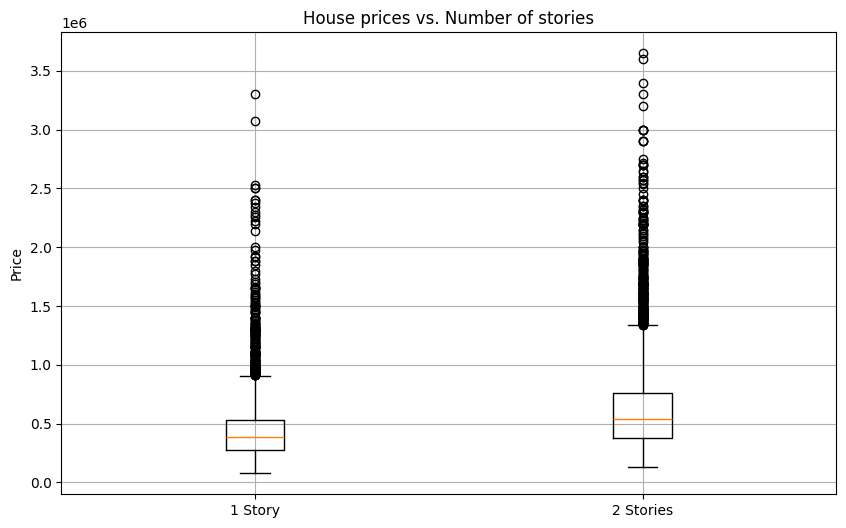

In [48]:
# group var / price
price_groups = [one_story_prices.dropna(), two_story_prices.dropna()]

# box plot
boxplot_labels = ['1 Story', '2 Stories']
plt.figure(figsize=(10, 6))
plt.boxplot(price_groups, tick_labels=boxplot_labels)
plt.title('House prices vs. Number of stories')
plt.ylabel('Price')
plt.grid(True)
plt.show()

Same box plot as before which demonstrates similar finding, but not as dramatic. The mean and median price of a two story house is higher than a 1 story house. There is also a bit more variation in the 2 story home prices.

In [49]:
# redefine vars w/ empty term for linear model
continuous_vars = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
response_var = 'price'
linear_models = {}

# fit a simple linear model for each predictor
for var in continuous_vars:
    # define the independent variable and y=price/response/intercept
    X = sm.add_constant(df_train[var])
    y = df_train[response_var]

    # OLS to minimize sum of square diff and determine line of best fit
    model = sm.OLS(y, X).fit()
    linear_models[var] = model

    print(f"Linear fit summary; Price vs. {var}")
    print(model.summary())

Linear fit summary; Price vs. sqft_living
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                 1.109e+04
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        14:55:11   Log-Likelihood:            -1.7763e+05
No. Observations:               12866   AIC:                         3.553e+05
Df Residuals:                   12864   BIC:                         3.553e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const   

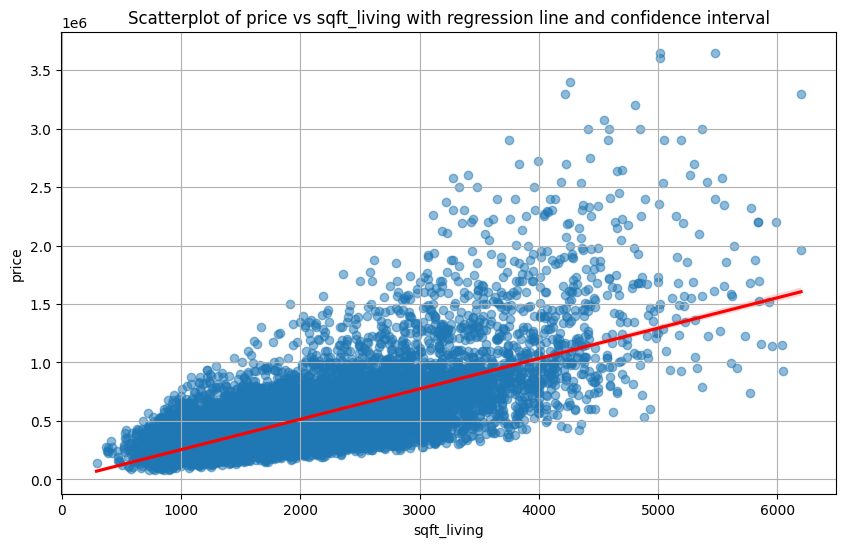

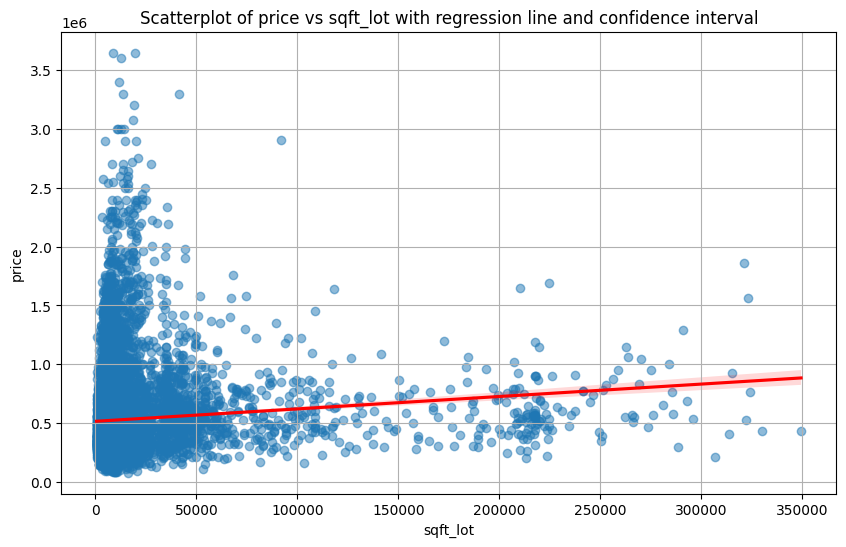

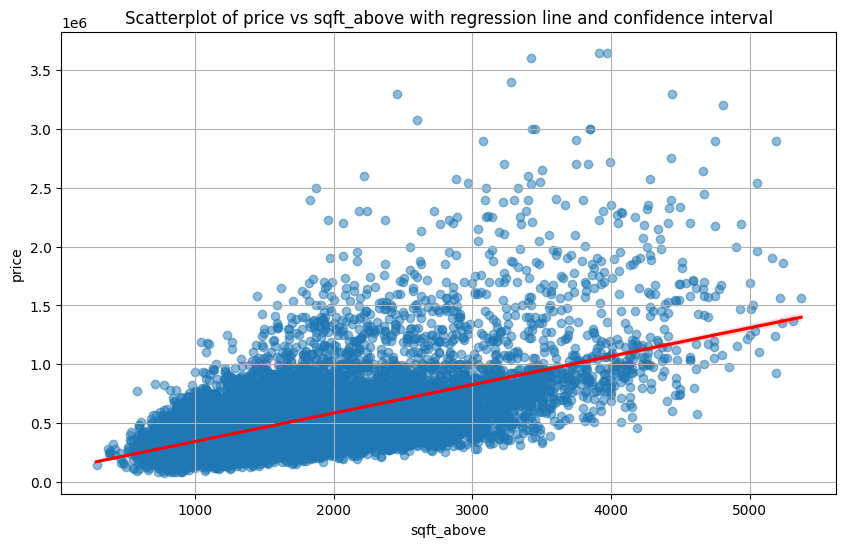

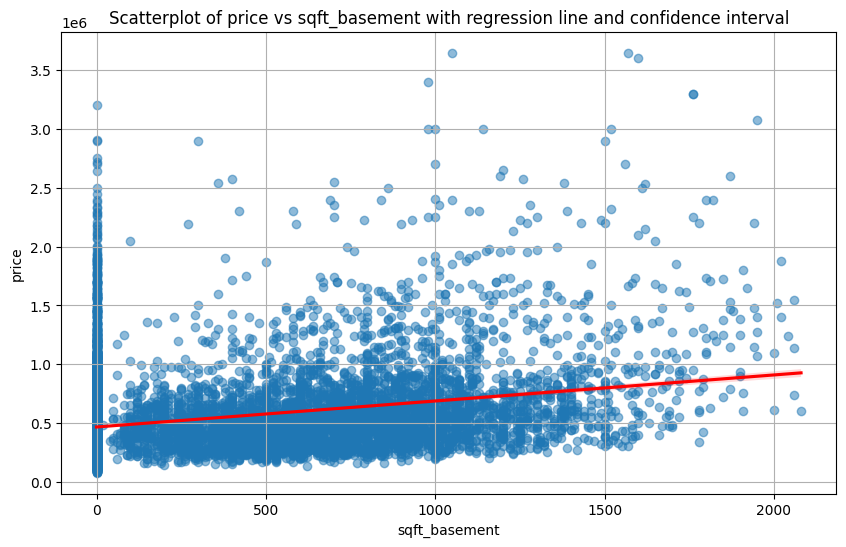

In [50]:
continuous_vars = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
response_var = 'price'

# scatter w/ regression and CI
for var in continuous_vars:
    plt.figure(figsize=(10, 6))
    sns.regplot(x=df_train[var], y=df_train[response_var], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f'Scatterplot of {response_var} vs {var} with regression line and confidence interval')
    plt.xlabel(var)
    plt.ylabel(response_var)
    plt.grid(True)
    plt.show()

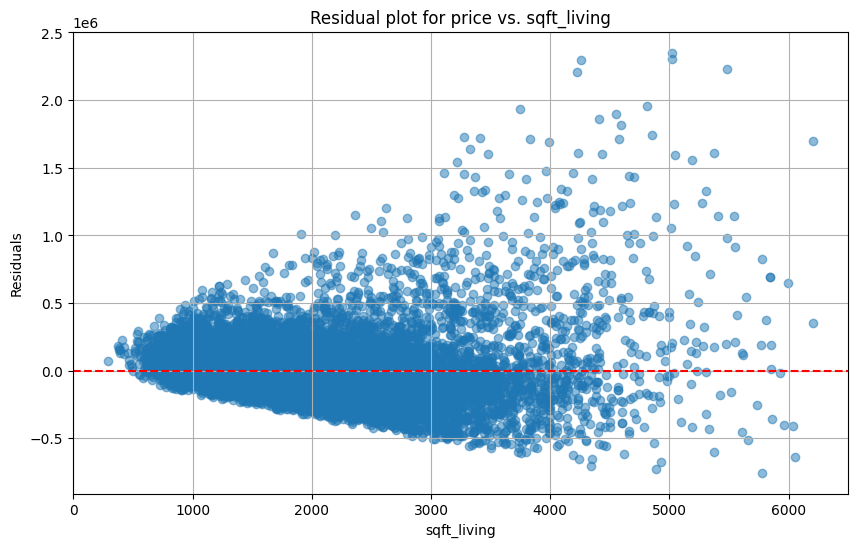

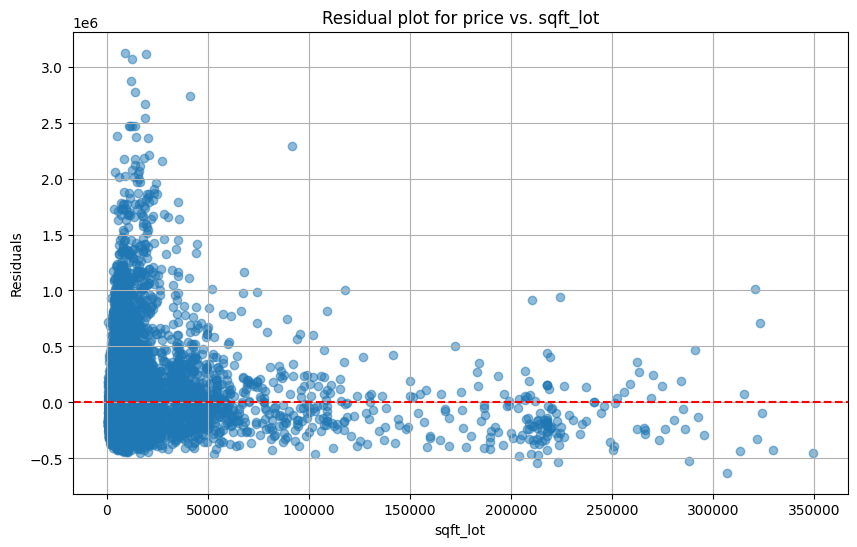

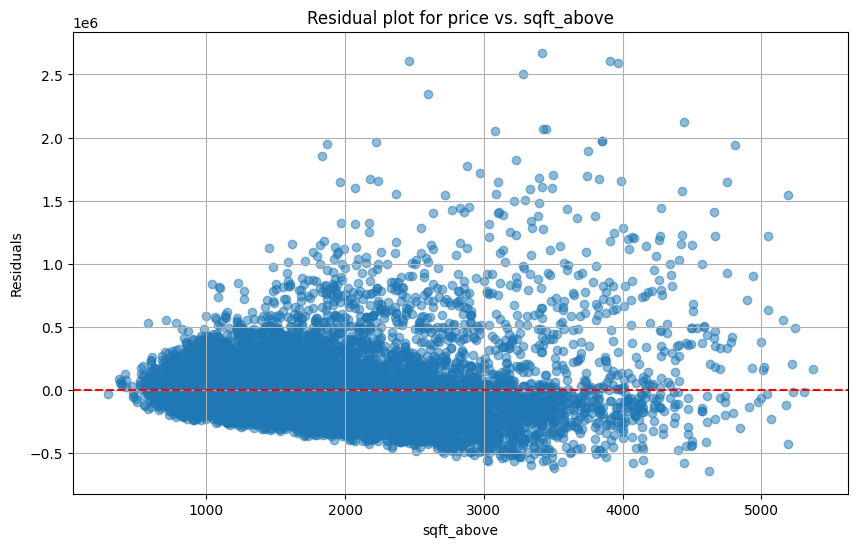

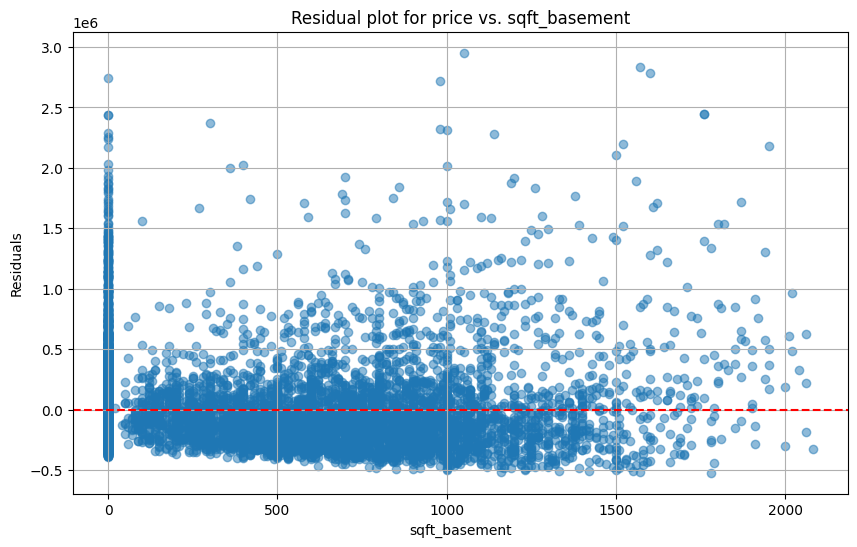

In [51]:
continuous_vars = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for var in continuous_vars:
    model = linear_models[var]

    # calculate residuals
    residuals = model.resid

    # Create the residual plot (residuals vs. predictor)
    plt.figure(figsize=(10, 6))
    plt.scatter(x=df_train[var], y=residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f'Residual plot for price vs. {var}')
    plt.xlabel(var)
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

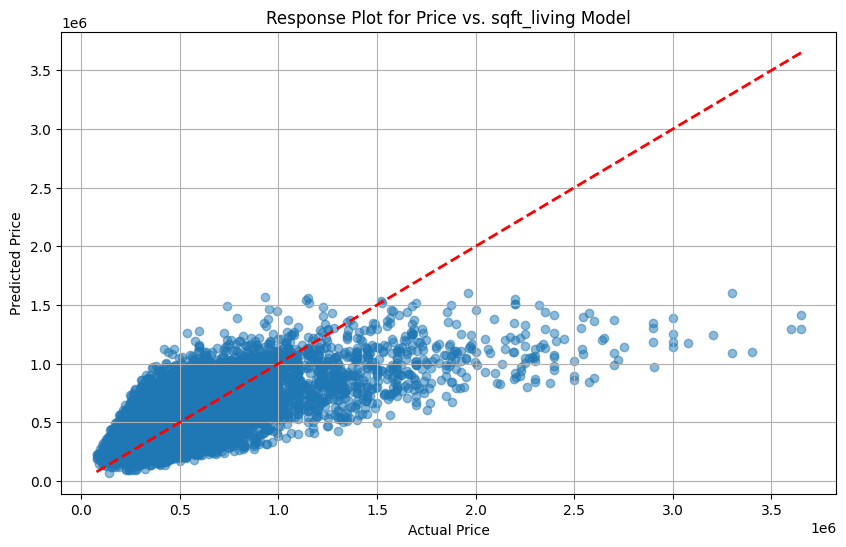

In [52]:
# price vs sqft living
model_name = 'sqft_living'
model = linear_models[model_name]
actual_values = df_train['price']

# model predicted price
predicted_values = model.predict(sm.add_constant(df_train[model_name]))

# predicted vs actual price
plt.figure(figsize=(10, 6))
plt.scatter(x=actual_values, y=predicted_values, alpha=0.5)
plt.plot([actual_values.min(), actual_values.max()], [actual_values.min(), actual_values.max()], 'r--', lw=2) # perfect predict line
plt.title(f'Response Plot for Price vs. {model_name} Model')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.show()

The model suggests thats sqft_living is the best predictor of housing price with an R2 of 0.46 which makes intuitive sense. sqft_above was the 2nd best predictor with an R2 of 0.34 which also makes sense given the way above ground sqft is generally valued over below ground sqft. Those 2 variables had the strongest trends. Sqft_basement had an R2 of 0.083, but not as much as sqft_living and sqft_above and all of that taken together makes sense. Sqft_lot had an R2 of 0.008 so I dont think it was very useful in predicting the price, but given the p-value its statistically significant at predicting the home price. All of the variables had a p-value < 0.05, so they were all stastistically significant in predicting the home price, but it seemed like sqft_living and sqft_above were much more useful, although the R2 of sqft_living was only 0.46, so it seems like the variation in price isnt explained well by any of these variables and perhaps a multivariable analysis would be more helpful.

The diagnostics from OLS suggest the error is not normally distributed Prob(omnibus)=0 and the pvalues and CI may be inaccurate. There is a positive skew (2.1-2.7) and kurtosis (14-15) which from what I read can be should be around 3 and values >3 are considered leptokuric which basically means many extreme outliers in the tails. In the context of house prices it would make sense there are likely very valuable homes far outside of the average price.


In [53]:
from sklearn.metrics import mean_squared_error
import numpy as np

# define cont vars
continuous_vars = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

# repeat
for var in continuous_vars:
    model = linear_models[var]
    r_squared = model.rsquared
    p_value = model.pvalues[var]
    actual_values = df_train['price']
    X_pred = sm.add_constant(df_train[var])
    predicted_values = model.predict(X_pred)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

    print(f"\nModel: Price vs. {var}")
    print(f"  R-squared: {r_squared:.4f}")
    print(f"  P-value ({var}): {p_value:.4f}")
    print(f"  RMSE: {rmse:.2f}")


Model: Price vs. sqft_living
  R-squared: 0.4629
  P-value (sqft_living): 0.0000
  RMSE: 239795.41

Model: Price vs. sqft_lot
  R-squared: 0.0079
  P-value (sqft_lot): 0.0000
  RMSE: 325910.44

Model: Price vs. sqft_above
  R-squared: 0.3403
  P-value (sqft_above): 0.0000
  RMSE: 265775.42

Model: Price vs. sqft_basement
  R-squared: 0.0831
  P-value (sqft_basement): 0.0000
  RMSE: 313313.41


Similar to before.. sqft_living has the highest r2(R2 0.4629) and explains more of the varability in house prices. The pvalue is 0.000, although im not sure thats accurate as discussed before. sqft_living also has the lowest RMSE (239795), so compared to the other models sqft_living predicts prices that are closer to the actual.

In [54]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import statsmodels.api as sm

continuous_vars = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
response_var = 'price'

# calculate metrics per model using val
for var in continuous_vars:
    model = linear_models[var]
    actual_values_val = df_val[response_var]
    X_val = sm.add_constant(df_val[var])
    predicted_values_val = model.predict(X_val)

    # calculate r2 and rmse on the validation set
    r_squared_val = r2_score(actual_values_val, predicted_values_val)
    rmse_val = np.sqrt(mean_squared_error(actual_values_val, predicted_values_val))

    print(f"\nModel: Price vs. {var}")
    print(f"  R-squared (Validation): {r_squared_val:.4f}")
    print(f"  RMSE (Validation): {rmse_val:.2f}")


Model: Price vs. sqft_living
  R-squared (Validation): 0.4618
  RMSE (Validation): 252237.92

Model: Price vs. sqft_lot
  R-squared (Validation): 0.0060
  RMSE (Validation): 342799.54

Model: Price vs. sqft_above
  R-squared (Validation): 0.3453
  RMSE (Validation): 278196.78

Model: Price vs. sqft_basement
  R-squared (Validation): 0.0815
  RMSE (Validation): 329515.05


The findings using the validation dataset are consistent with the training data. Sqft_living still has the highest R2 and lowest RMSE and is still the best predictor of housing price. The R2 and RMSE was similar on the training and validation sets and suggests the model can generalize or at least is not overfit to the training split. The results seem reasonable and are consistent with my understanding of the housing market.

---

